In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns; sns.set_theme()
from sklearn import tree
import graphviz
from dtreeviz.trees import dtreeviz
from sklearn.naive_bayes import GaussianNB

## Reading Data and Preprocessing

In [83]:
df = pd.read_csv('covid_train.csv')
#df = df.dropna()
train_length = len(df)
df_test = pd.read_csv('covid_tests.csv')
test_length = len(df_test)
#df = pd.concat([df,df_test],axis=0)

In [84]:
for i in set(df.loc[:,"Reporting_PHU_City"]):
    lat = set(df[df.loc[:,"Reporting_PHU_City"]==i].loc[:,"Reporting_PHU_Latitude"])
    lon = set(df[df.loc[:,"Reporting_PHU_City"]==i].loc[:,"Reporting_PHU_Longitude"])
    print(i,"\t",lat,lon)
print("No of sets ",len(set(df.loc[:,"Reporting_PHU_City"])))

Ottawa 	 {45.3456651} {-75.7639122}
Thorold 	 {43.1165366} {-79.2412197}
Simcoe 	 {42.84782526} {-80.30381491}
New Liskeard 	 {47.5092835} {-79.681632}
Sault Ste. Marie 	 {46.5323728} {-84.3148358}
Windsor 	 {42.3087965} {-83.0336705}
Mississauga 	 {43.6474713} {-79.7088933}
Sudbury 	 {46.46609195} {-80.99805884}
Guelph 	 {43.5248813} {-80.2337433}
Toronto 	 {43.65659125} {-79.37935801}
Brockville 	 {44.61584261} {-75.70283308}
Oakville 	 {43.41399692} {-79.74479581}
Point Edward 	 {42.98641646} {-82.40480836}
Newmarket 	 {44.048023} {-79.480239}
Pembroke 	 {45.799406} {-77.118727}
Peterborough 	 {44.30163229} {-78.32134748}
Barrie 	 {44.41071258} {-79.68630597}
Thunder Bay 	 {48.4005716} {-89.25885079999998}
Hamilton 	 {43.2576311} {-79.87134089}
Cornwall 	 {45.02915233} {-74.73629779}
Whitby 	 {43.898604999999996} {-78.940341}
Owen Sound 	 {44.57619612} {-80.94097993}
North Bay 	 {46.31320706} {-79.46784050000002}
Timmins 	 {48.47251} {-81.32875}
Brantford 	 {43.151811} {-80.27437415

### From the above, it is clear that every city corresponds to a unique set of co-ordinates. This clears up the fact that no city has two different Public Health Units reporting covid results. Also, city and co-ordinates convey the same information, so we can choose to use one over the other to avoid data redundancy. For convenience we'll go with City information and drop co-ordinates.

In [85]:
def find_mode(df):
    AG = pd.unique(df.Age_Group)
    mode = np.zeros((9,1))
    for i in list(df.loc[:,"Age_Group"].values):
        if str(i)!='nan':
            i = int(i)
            mode[i-1]+=1
    m = np.argmax(mode)
    return m

In [86]:
df['Age_Group'] = df['Age_Group'].replace('<20',1).replace('20s',2).replace('30s',3).replace('40s',4).replace('50s',5).replace('60s',6).replace('70s',7).replace('80s',8).replace('90s',9)
df_oc_fatal = df[df["Outcome1"]=="Fatal"]
df_oc_res = df[df["Outcome1"]=="Resolved"]
df_oc_nres = df[df["Outcome1"]=="Not Resolved"]
print("'Fatal' age Mode ",find_mode(df_oc_fatal))
print("'Resolved' age Mode ",find_mode(df_oc_res))
print("'Not Resolved' age Mode ",find_mode(df_oc_nres))
df_oc_fatal["Age_Group"]=df_oc_fatal["Age_Group"].replace(np.nan,7)
df_oc_res["Age_Group"]=df_oc_res["Age_Group"].replace(np.nan,1)
df_oc_nres["Age_Group"]=df_oc_nres["Age_Group"].replace(np.nan,1)
df = pd.concat([df_oc_fatal,df_oc_res,df_oc_nres])

'Fatal' age Mode  7
'Resolved' age Mode  1
'Not Resolved' age Mode  1


In [87]:
df.describe(include='all')

,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
count,14851.000000,14851,14851,14851,5831,14851.000000,14851.000000,14851
unique,NaN,4,6,34,1,NaN,NaN,3
top,NaN,FEMALE,OB,Toronto,Yes,NaN,NaN,Fatal
freq,NaN,7499,5389,5158,5831,NaN,NaN,4951
mean,5.168608,NaN,NaN,NaN,NaN,43.741457,-79.565291,NaN
std,2.615903,NaN,NaN,NaN,NaN,0.752952,1.589850,NaN
min,1.000000,NaN,NaN,NaN,NaN,42.308796,-94.488254,NaN
25%,3.000000,NaN,NaN,NaN,NaN,43.647471,-79.708893,NaN
50%,5.000000,NaN,NaN,NaN,NaN,43.656591,-79.379358,NaN
75%,8.000000,NaN,NaN,NaN,NaN,43.656591,-79.379358,NaN


# Feature analysis

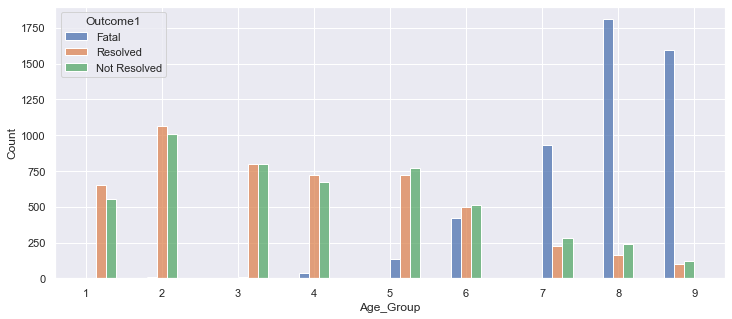

In [11]:
fig1 = plt.figure(figsize=(12,5))
sns.histplot(data=df, x="Age_Group", hue = "Outcome1", multiple='dodge')

### Age seems to be a crucial feature looking at this histogram. The above graph reflects the medical community's claim that covid is dangerous to older population.

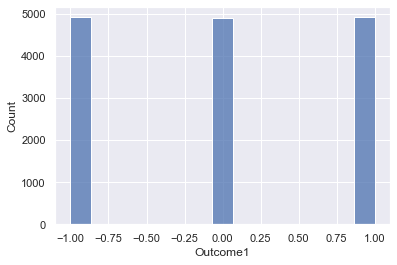

In [125]:
sns.histplot(data=df, x='Outcome1')

### Outcome1 seems to be balanced. There is no skew towards one particular outcome class which is a good thing.

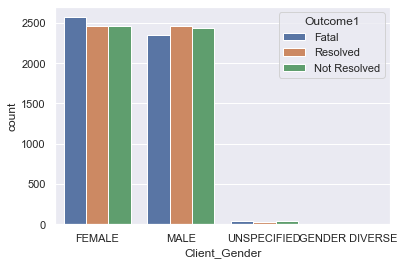

In [116]:
sns.countplot(data = df,x="Client_Gender", hue="Outcome1")

### GENDER DIVERSE seems to be a serious outlier with no more than a couple of values. We can explore removing this. There does not seem to be any sort of imbalance with regards to outcome by gender. Outcome seems to be balanced across gender. On the contrary this could be specific to the dataset and not true in general. We should investigate further before concluding on the significance of this feature.

## GENDER VS AGE VS INFECTION
### This comparison seems logical

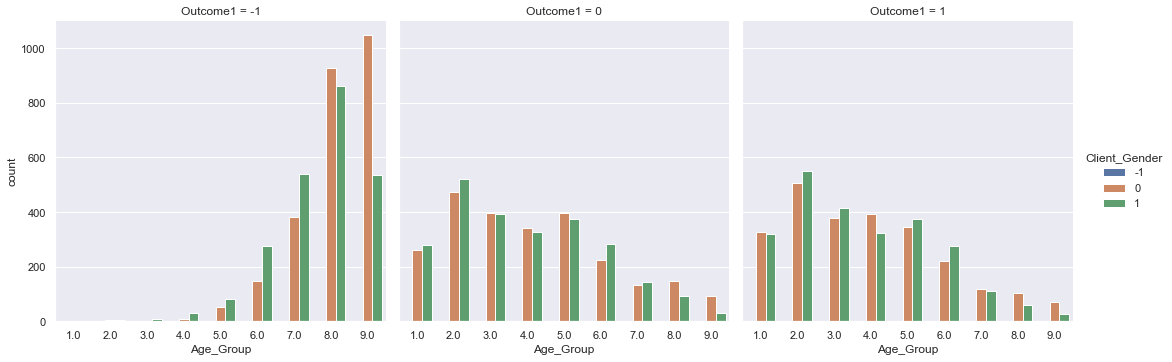

In [66]:
x = list(df.columns)
cols_needed = ["Age_Group","Client_Gender","Outcome1"]
for col in cols_needed:
    x.remove(col)
df_tailor = df.drop(columns=x)
df_tailor['Client_Gender'] = df_tailor['Client_Gender'].replace("MALE",1).replace("FEMALE",0).replace("GENDER DIVERSE",-1)
sns.catplot(data = df_tailor, x = "Age_Group", hue = 'Client_Gender',col ="Outcome1", kind="count")

### There seems to be a decrease in fatalities among very old men which is kind of counter intuitive from what medical community claims. Data can be deceiving so lets examine for class imbalance.

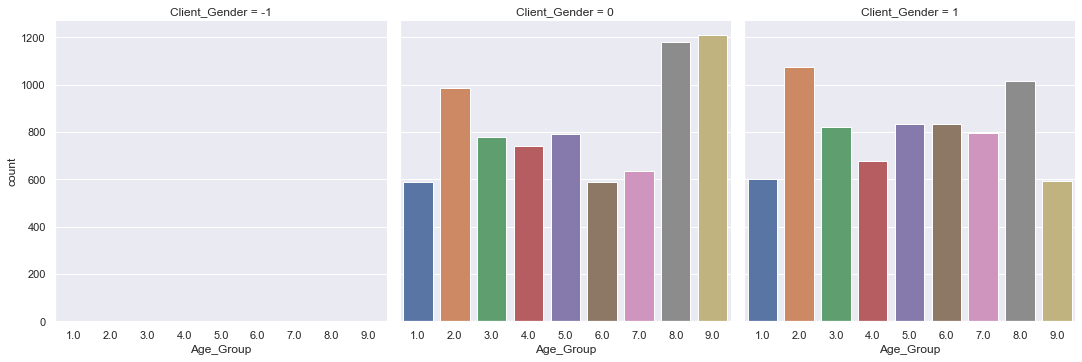

In [67]:
sns.catplot(data = df_tailor, x = "Age_Group", col = 'Client_Gender', kind="count")

### As suspected, there seems to be class imbalance. There are very less very old men in our count. Now we can confidently say that "Client_Gender" feature is not of much use to our analysis. It does not seem to provide any useful information to deduce outcome.

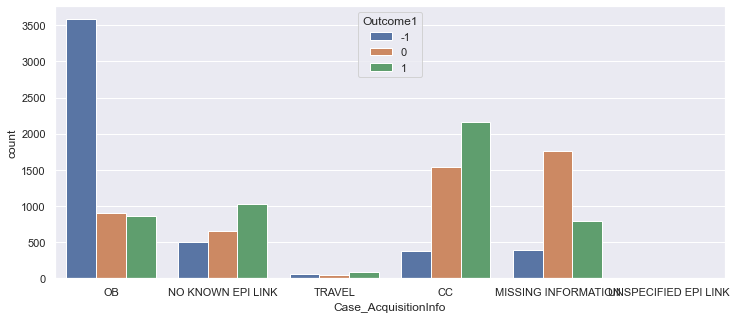

In [162]:
fig1 = plt.figure(figsize=(12,5))
sns.countplot(data= df, x = "Case_AcquisitionInfo", hue = "Outcome1")

### OB, CC and MISSING INFORMATION seem to be contain useful information as each one peaks at a different outcome. Distribution of NO KNOWN EPI LINK, TRAVEL and UNSPECIFIED EPI LINK seem to be similar so we'll try combining them.

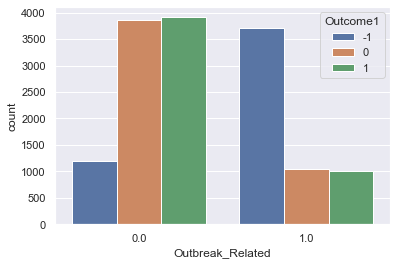

In [76]:
sns.countplot(data= df, x = "Outbreak_Related", hue = "Outcome1")

### This feature is definitely useful to differentiate Fatalities from the rest but between the other two, its not so much useful. Perhaps it can vary with age.

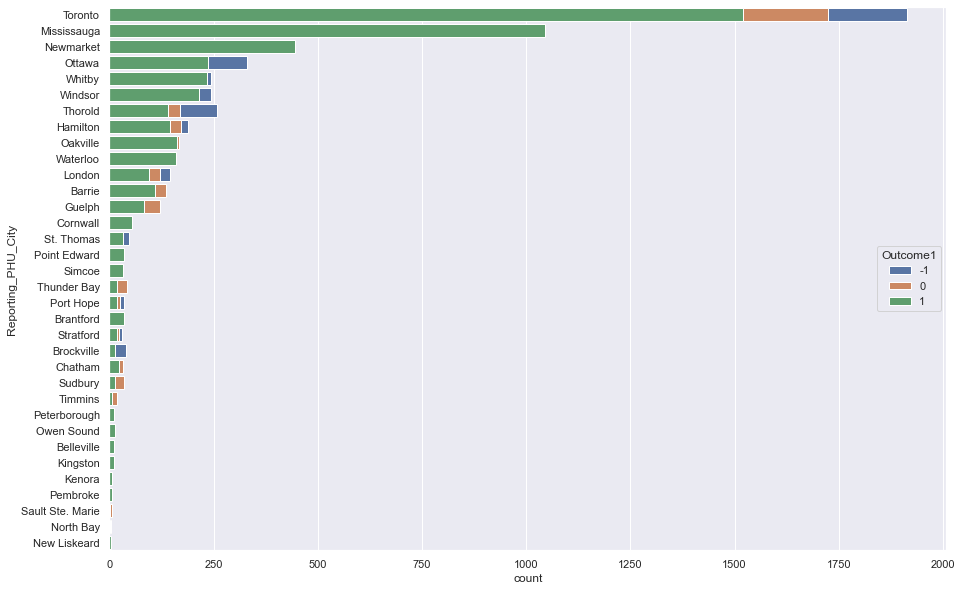

In [400]:
fig1 = plt.figure(figsize = (15,10))
sns.countplot(data= df, y = "Reporting_PHU_City", hue="Outcome1",dodge=False, order = df['Reporting_PHU_City'].value_counts().index)

### Only few Cities have clear distinction. We can keep only those and combine the rest into a single category.
We'll keep [Toronto, Mississauga, Newmarket, Ottawa, Whitby, Windsor, Thorold, Hamilton, Oakville, Waterloo, London, Barrie, Guelph, Cornwall, St. Thomas, Thunder Bay, Brockville,Chatham, Sudbury, Timmins] 

In [93]:
df_tailor = df.copy()
i=1
for city in list(df["Reporting_PHU_City"].unique()):
    df_tailor["Reporting_PHU_City"] = df_tailor["Reporting_PHU_City"].replace(city,i)
    print(city,"\t",i)
    i+=1

Oakville 	 1
Guelph 	 2
Barrie 	 3
Toronto 	 4
Ottawa 	 5
Newmarket 	 6
Thorold 	 7
Whitby 	 8
Windsor 	 9
Waterloo 	 10
Mississauga 	 11
New Liskeard 	 12
Simcoe 	 13
Hamilton 	 14
Thunder Bay 	 15
London 	 16
Point Edward 	 17
St. Thomas 	 18
Kingston 	 19
Cornwall 	 20
Port Hope 	 21
North Bay 	 22
Stratford 	 23
Owen Sound 	 24
Brantford 	 25
Chatham 	 26
Brockville 	 27
Timmins 	 28
Kenora 	 29
Sudbury 	 30
Belleville 	 31
Peterborough 	 32
Sault Ste. Marie 	 33
Pembroke 	 34


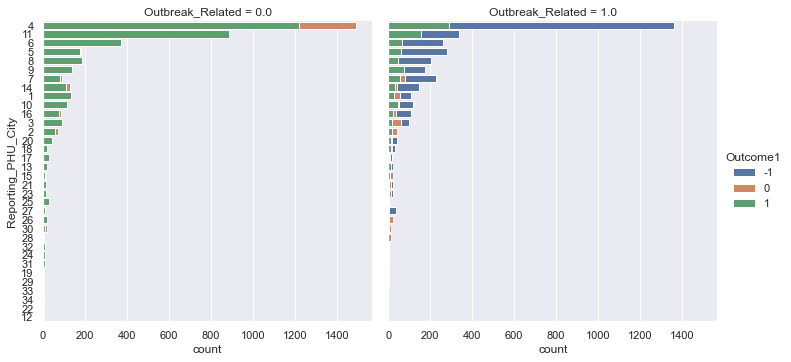

In [97]:
sns.catplot(data = df_tailor, y = "Reporting_PHU_City", hue = 'Outcome1',col ="Outbreak_Related", kind="count",dodge=False, order = df_tailor['Reporting_PHU_City'].value_counts().index)

### Outbreak feature seems to pair well with City so we'll keep both of them in our analysis.

# Applying Preprocessing and inferences from Feature Selection Activity

In [88]:
def step1(df,train = True):    
    df['Age_Group'] = df['Age_Group'].replace('<20',1).replace('20s',2).replace('30s',3).replace('40s',4).replace('50s',5).replace('60s',6).replace('70s',7).replace('80s',8).replace('90s',9)
    if train:
        df['Outcome1']=df['Outcome1'].replace('Resolved',1).replace('Fatal',-1).replace('Not Resolved',0)
    df['Outbreak_Related'] = df['Outbreak_Related'].replace('Yes',1).replace(np.nan,0)
    df['Client_Gender'] = df['Client_Gender'].replace('UNSPECIFIED',np.nan)
    df['Case_AcquisitionInfo']=df['Case_AcquisitionInfo'].replace('TRAVEL','OTHERWISE').replace('NO KNOWN EPI LINK','OTHERWISE').replace('UNSPECIFIED EPI LINK','OTHERWISE')
    df=df.dropna()
    return df
#df = df.dropna()
#df_back_up = df.copy()

In [89]:
#countries_chosen = ["Toronto", "Mississauga", "Newmarket", "Ottawa", "Whitby", "Windsor", "Thorold", "Hamilton", "Oakville", "Waterloo", "London", "Barrie", "Guelph", "Cornwall", "St. Thomas", "Thunder Bay", "Brockville"]

#    countries_chosen = ["Toronto", "Ottawa", "Whitby", "Windsor", "Thorold", "Hamilton", "London", "Barrie", "Guelph", "St. Thomas", "Thunder Bay", "Brockville", "Sudbury", "Chatham", "Timmins"] best
def step2(df):
    countries_chosen = ["Toronto", "Mississauga", "Newmarket", "Ottawa", "Whitby", "Windsor", "Thorold", "Hamilton", "Oakville", "Waterloo", "London", "Barrie", "Guelph", "Cornwall", "St. Thomas", "Thunder Bay", "Brockville"]
    for country in list(df["Reporting_PHU_City"].unique()):
        if country not in countries_chosen:
            df['Reporting_PHU_City'] = df['Reporting_PHU_City'].replace(country,"Otherwise")
    return df

In [90]:
def step3(df):    
    gender_dummy = pd.get_dummies(df.Client_Gender,prefix='Gender')
    Case_Aq_dummy = pd.get_dummies(df.Case_AcquisitionInfo,prefix='Case_Aq')
    City_dummy = pd.get_dummies(df.Reporting_PHU_City,prefix='City')
    drop_clm = ['Reporting_PHU_City','Client_Gender','Case_AcquisitionInfo','Reporting_PHU_Latitude','Reporting_PHU_Longitude']
    df = df.drop(columns=drop_clm)
    df = pd.concat([df,City_dummy,Case_Aq_dummy],axis=1)
    return df

In [91]:
df_backup = df.copy()

In [92]:
df = df_backup.copy()

In [93]:
df['Age_Group'] = df['Age_Group'].replace('<20',1).replace('20s',2).replace('30s',3).replace('40s',4).replace('50s',5).replace('60s',6).replace('70s',7).replace('80s',8).replace('90s',9)
df['Outcome1']=df['Outcome1'].replace('Resolved',1).replace('Fatal',-1).replace('Not Resolved',0)
df['Outbreak_Related'] = df['Outbreak_Related'].replace('Yes',1).replace(np.nan,0)
df['Client_Gender'] = df['Client_Gender'].replace('UNSPECIFIED',np.nan)
df['Case_AcquisitionInfo']=df['Case_AcquisitionInfo'].replace('TRAVEL','OTHERWISE').replace('NO KNOWN EPI LINK','OTHERWISE').replace('UNSPECIFIED EPI LINK','OTHERWISE')
df = df.dropna()

countries_chosen = ["Toronto", "Mississauga", "Newmarket", "Ottawa", "Whitby", "Windsor", "Thorold", "Hamilton", "Oakville", "Waterloo", "London", "Barrie", "Guelph", "Cornwall", "St. Thomas", "Thunder Bay", "Brockville"]
for country in list(df["Reporting_PHU_City"].unique()):
    if country not in countries_chosen:
        df['Reporting_PHU_City'] = df['Reporting_PHU_City'].replace(country,"Otherwise")

gender_dummy = pd.get_dummies(df.Client_Gender,prefix='Gender')
Case_Aq_dummy = pd.get_dummies(df.Case_AcquisitionInfo,prefix='Case_Aq')
City_dummy = pd.get_dummies(df.Reporting_PHU_City,prefix='City')
drop_clm = ['Reporting_PHU_City','Client_Gender','Case_AcquisitionInfo','Reporting_PHU_Latitude','Reporting_PHU_Longitude']
df = df.drop(columns=drop_clm)
df = pd.concat([df,City_dummy,Case_Aq_dummy],axis=1)

In [94]:
#df = step1(df)
#df = step2(df)
#df = step3(df)

In [95]:
feature_cols = list(df.columns)
target_col = 'Outcome1'
feature_cols.remove(target_col)
df_feat = df[feature_cols]
df_target = df.drop(columns = feature_cols)
class_nms = ['Fatal','Not Resolved','Resolved']

In [96]:
df_feat

,Age_Group,Outbreak_Related,City_Barrie,City_Brockville,City_Cornwall,City_Guelph,City_Hamilton,City_London,City_Mississauga,City_Newmarket,...,City_Thorold,City_Thunder Bay,City_Toronto,City_Waterloo,City_Whitby,City_Windsor,Case_Aq_CC,Case_Aq_MISSING INFORMATION,Case_Aq_OB,Case_Aq_OTHERWISE
4,9.0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,6.0,1.0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
6,7.0,0.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
8,9.0,1.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
9,9.0,1.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14838,8.0,1.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
14841,3.0,0.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
14842,2.0,0.0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
14846,1.0,0.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [97]:
X_train,X_test,Y_train,Y_test = train_test_split(df_feat,df_target, test_size = 0.2, random_state= 225)

Text(0, 0.5, 'Accuracy')

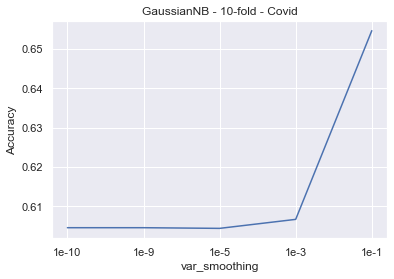

In [98]:
#GaussianNB
kf = KFold(n_splits=10)
performance_dict = {}
var_sm_list = [1e-10, 1e-9, 1e-5, 1e-3, 1e-1]
for var_sm in var_sm_list:
    acc = []
    for train_index,val_index in kf.split(X_train):
        clf = GaussianNB(var_smoothing=var_sm)
        X_Tr = X_train.iloc[train_index,:]
        Y_Tr = Y_train.iloc[train_index,:]
        X_V = X_train.iloc[val_index,:]
        Y_V = Y_train.iloc[val_index,:]
        clf = clf.fit(X_Tr, Y_Tr)
        Y_P = clf.predict(X_V)
        acc.append(metrics.accuracy_score(Y_V, Y_P))
    performance_dict[var_sm] = np.mean(acc)
accuracies = list(performance_dict.values())
plt.title("GaussianNB - 10-fold - Covid")
plt.plot([1,2,3,4,5], accuracies)
plt.xticks([1,2,3,4,5],['1e-10','1e-9','1e-5','1e-3','1e-1'])
plt.xlabel('var_smoothing')
plt.ylabel('Accuracy')


### We are evaluating the models with 'accuracy' performance measure. We can see that increasing var_smoothing variable in the given range increases the performance of the model. The accuracy peaks at var_smoothing = 0.1 which we will choose for evaluation with test set. var_smoothing is essentially an additive value that we are incorporating in the calculation for mathematical stability. 

In [99]:
clf = GaussianNB(var_smoothing=0.1)
clf = clf.fit(X_train,Y_train)
Y_P = clf.predict(X_test)
GNB_Test_Acc = metrics.accuracy_score(Y_test, Y_P)
print("Gaussian Naive Bayes Test Accuracy at var_smoothing of 1e-1 is...", GNB_Test_Acc)

Gaussian Naive Bayes Test Accuracy at var_smoothing of 1e-1 is... 0.6731095286537809


## Impact of var_smoothing in covid dataset
### In gaussian distribution, we have two parameters that define it, namely mean(mu) and variance(sigma). The sigma term occurrs in the denominator, so it is vital to account for 0 variance in order to ensure mathematical calculation stability. This is analogous to the concept of Laplace smoothing but is more specific to gaussian distribution.
### Through Naive Bayes, we are essentially estimating the mean and variance of the underlying distribution of the atrtibutes. Setting a very small value of var_smoothing does not alter the estimated variance much. The cavieat here is that one can see from the below set of values that the categorical inputs sometimes tend to have very less variance due to the nature of the encoding (one-hot). This will also depend on the frequency of occurrence of a categorical item. This is where var_smoothing comes in. var_smoothing can be considered as a tuning parameter that decides the quantum of variance we add to all the parameters. So we are artificially boosting variance. This essentially gives better shape(gaussian like) to features and helps us deal with mathematical complications of very small variance. But what happens if we increase it too much? This will boost the variance disproportionately and the more we increase, the distribution will end up looking more like a uniform distribution. This will obviously deteriorate the performance. Let's see if that is that case.

In [100]:
np.var(X_train, axis=0)

Age_Group                      6.813746
Outbreak_Related               0.238724
City_Barrie                    0.022933
City_Brockville                0.004137
City_Cornwall                  0.010153
City_Guelph                    0.016505
City_Hamilton                  0.032367
City_London                    0.024546
City_Mississauga               0.142208
City_Newmarket                 0.072844
City_Oakville                  0.028953
City_Otherwise                 0.040671
City_Ottawa                    0.051165
City_St. Thomas                0.007238
City_Thorold                   0.037322
City_Thunder Bay               0.004977
City_Toronto                   0.226620
City_Waterloo                  0.030544
City_Whitby                    0.039117
City_Windsor                   0.037400
Case_Aq_CC                     0.199313
Case_Aq_MISSING INFORMATION    0.160609
Case_Aq_OB                     0.231564
Case_Aq_OTHERWISE              0.134331
dtype: float64

Text(0, 0.5, 'Accuracy')

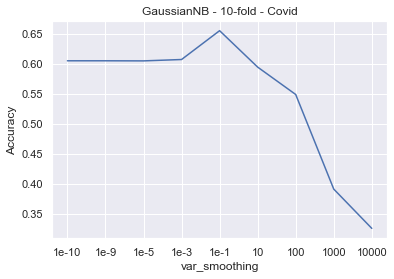

In [101]:
#GaussianNB
kf = KFold(n_splits=10)
performance_dict = {}
var_sm_list = [1e-10, 1e-9, 1e-5, 1e-3, 1e-1, 10, 100, 1000, 10000]
for var_sm in var_sm_list:
    acc = []
    for train_index,val_index in kf.split(X_train):
        clf = GaussianNB(var_smoothing=var_sm)
        X_Tr = X_train.iloc[train_index,:]
        Y_Tr = Y_train.iloc[train_index,:]
        X_V = X_train.iloc[val_index,:]
        Y_V = Y_train.iloc[val_index,:]
        clf = clf.fit(X_Tr, Y_Tr)
        Y_P = clf.predict(X_V)
        acc.append(metrics.accuracy_score(Y_V, Y_P))
    performance_dict[var_sm] = np.mean(acc)
accuracies = list(performance_dict.values())
plt.title("GaussianNB - 10-fold - Covid")
plt.plot([1,2,3,4,5,6,7,8,9], accuracies)
plt.xticks([1,2,3,4,5,6,7,8,9],['1e-10','1e-9','1e-5','1e-3','1e-1','10','100','1000','10000'])
plt.xlabel('var_smoothing')
plt.ylabel('Accuracy')


### As expected performance drops if we increase the var_smoothing further. The plot supports our claim. From the Decision Tree plot of covid for depth of 3, we noted that the most informative features are "Age_Group", "MISSING_INFORMATION", "Outbreak_Related". These features are not sparse in nature and hence they can support the prediction calculation at lower values of var_smoothing. As we gradually increase the var_smoothing, it boosts the variance of the many sparse features we have in our dataset (one hot encoded city dataset) allowing them to add contribution towards prediction. But as we blow up the value of var_smoothing, it blows up the distribution disproportionately to a point that it resembles more like a uniform distribution rather than a gaussian.

In [43]:
#GaussianNB
kf = KFold(n_splits=10)
var_sm_list = [1e-5, 1e-3, 1e-1, 10, 100, 1000, 10000]
for var_sm in var_sm_list:
    for train_index,val_index in kf.split(X_train):
        clf = GaussianNB(var_smoothing=var_sm)
        X_Tr = X_train.iloc[train_index,:]
        Y_Tr = Y_train.iloc[train_index,:]
        X_V = X_train.iloc[val_index,:]
        Y_V = Y_train.iloc[val_index,:]
        clf = clf.fit(X_Tr, Y_Tr)
        Y_P = clf.predict(X_V)
    var = pd.DataFrame()
    var[0]=(list(list(clf.sigma_)[0]))
    var[1]=(list(list(clf.sigma_)[1]))
    var[2]=(list(list(clf.sigma_)[2]))
    var.columns = ["Fatal","Not Resolved","Resolved"]
    var.index = list(X_train.columns)
    print("Var_smoothing is..",var_sm)
    print(var.T.Age_Group)
    print("")

Var_smoothing is.. 1e-05
Fatal           1.347717
Not Resolved    4.421428
Resolved        4.096063
Name: Age_Group, dtype: float64

Var_smoothing is.. 0.001
Fatal           1.354433
Not Resolved    4.428144
Resolved        4.102780
Name: Age_Group, dtype: float64

Var_smoothing is.. 0.1
Fatal           2.026051
Not Resolved    5.099763
Resolved        4.774398
Name: Age_Group, dtype: float64

Var_smoothing is.. 10
Fatal           69.187924
Not Resolved    72.261635
Resolved        71.936270
Name: Age_Group, dtype: float64

Var_smoothing is.. 100
Fatal           679.750397
Not Resolved    682.824109
Resolved        682.498744
Name: Age_Group, dtype: float64

Var_smoothing is.. 1000
Fatal           6785.375133
Not Resolved    6788.448845
Resolved        6788.123480
Name: Age_Group, dtype: float64

Var_smoothing is.. 10000
Fatal           67841.622494
Not Resolved    67844.696206
Resolved        67844.370841
Name: Age_Group, dtype: float64



### We can see how the value blows up upon increasing beyong 0.1. This sums up our analysis on the impact of var_smoothing.

# Without preprocessing

In [47]:
df = pd.read_csv('covid_train.csv')
df['Age_Group'] = df['Age_Group'].replace('<20',1).replace('20s',2).replace('30s',3).replace('40s',4).replace('50s',5).replace('60s',6).replace('70s',7).replace('80s',8).replace('90s',9)
df['Outcome1']=df['Outcome1'].replace('Resolved',1).replace('Fatal',-1).replace('Not Resolved',0)
df['Outbreak_Related'] = df['Outbreak_Related'].replace('Yes',1).replace(np.nan,0)
#df['Client_Gender'] = df['Client_Gender'].replace('UNSPECIFIED',np.nan)
#df['Case_AcquisitionInfo']=df['Case_AcquisitionInfo'].replace('NO KNOWN EPI LINK','OTHERWISE').replace('UNSPECIFIED EPI LINK','OTHERWISE')
df = df.dropna()
gender_dummy = pd.get_dummies(df.Client_Gender,prefix='Gender')
Case_Aq_dummy = pd.get_dummies(df.Case_AcquisitionInfo,prefix='Case_Aq')
City_dummy = pd.get_dummies(df.Reporting_PHU_City,prefix='City')
drop_clm = ['Client_Gender','Case_AcquisitionInfo','Reporting_PHU_City']
df = df.drop(columns=drop_clm)
df = pd.concat([df,gender_dummy,Case_Aq_dummy, City_dummy],axis=1)
feature_cols = list(df.columns)
target_col = 'Outcome1'
feature_cols.remove(target_col)
df_feat = df[feature_cols]
df_target = df.drop(columns = feature_cols)
class_nms = ['Fatal','Not Resolved','Resolved']

In [48]:
X_train,X_test,Y_train,Y_test = train_test_split(df_feat,df_target, test_size = 0.2, random_state= 225)

Text(0, 0.5, 'Accuracy')

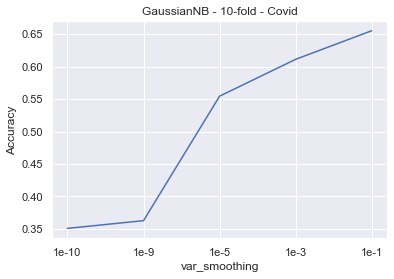

In [49]:
#GaussianNB
kf = KFold(n_splits=10)
performance_dict = {}
var_sm_list = [1e-10, 1e-9, 1e-5, 1e-3, 1e-1]
for var_sm in var_sm_list:
    acc = []
    for train_index,val_index in kf.split(X_train):
        clf = GaussianNB(var_smoothing=var_sm)
        X_Tr = X_train.iloc[train_index,:]
        Y_Tr = Y_train.iloc[train_index,:]
        X_V = X_train.iloc[val_index,:]
        Y_V = Y_train.iloc[val_index,:]
        clf = clf.fit(X_Tr, Y_Tr)
        Y_P = clf.predict(X_V)
        acc.append(metrics.accuracy_score(Y_V, Y_P))
    performance_dict[var_sm] = np.mean(acc)
accuracies = list(performance_dict.values())
plt.title("GaussianNB - 10-fold - Covid")
plt.plot([1,2,3,4,5], accuracies)
plt.xticks([1,2,3,4,5],['1e-10','1e-9','1e-5','1e-3','1e-1'])
plt.xlabel('var_smoothing')
plt.ylabel('Accuracy')


In [31]:
clf = GaussianNB(var_smoothing=1e-1)
clf = clf.fit(X_train,Y_train)
Y_P = clf.predict(X_test)
GNB_Test_Acc = metrics.accuracy_score(Y_test, Y_P)
print("Decision Tree Test Accuracy at depth of 1e-1 is...", GNB_Test_Acc)

Decision Tree Test Accuracy at depth of 1e-1 is... 0.6554395419333109


### In preprocessing, we removed a lot a categorical features by either eliminating some features that are redundant or by combining categorical features. Without preprocessing, when we employ one-hot encoding, the amount of sparse features blows up. This can explain the poor performance at lower values of var_smoothing. To investigate further, let us remove city which is very sparse in one-hot encoded form and see if it makes a difference.

Text(0, 0.5, 'Accuracy')

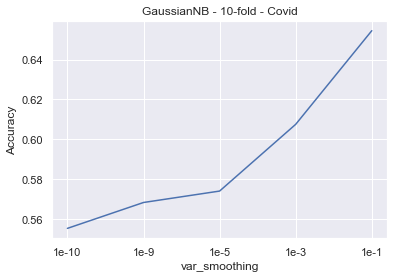

In [45]:
df = pd.read_csv('covid_train.csv')
df['Age_Group'] = df['Age_Group'].replace('<20',1).replace('20s',2).replace('30s',3).replace('40s',4).replace('50s',5).replace('60s',6).replace('70s',7).replace('80s',8).replace('90s',9)
df['Outcome1']=df['Outcome1'].replace('Resolved',1).replace('Fatal',-1).replace('Not Resolved',0)
df['Outbreak_Related'] = df['Outbreak_Related'].replace('Yes',1).replace(np.nan,0)
#df['Client_Gender'] = df['Client_Gender'].replace('UNSPECIFIED',np.nan)
#df['Case_AcquisitionInfo']=df['Case_AcquisitionInfo'].replace('NO KNOWN EPI LINK','OTHERWISE').replace('UNSPECIFIED EPI LINK','OTHERWISE')
df = df.dropna()
gender_dummy = pd.get_dummies(df.Client_Gender,prefix='Gender')
Case_Aq_dummy = pd.get_dummies(df.Case_AcquisitionInfo,prefix='Case_Aq')
City_dummy = pd.get_dummies(df.Reporting_PHU_City,prefix='City')
drop_clm = ['Client_Gender','Case_AcquisitionInfo','Reporting_PHU_City']
df = df.drop(columns=drop_clm)
df = pd.concat([df,gender_dummy,Case_Aq_dummy],axis=1)
feature_cols = list(df.columns)
target_col = 'Outcome1'
feature_cols.remove(target_col)
df_feat = df[feature_cols]
df_target = df.drop(columns = feature_cols)
class_nms = ['Fatal','Not Resolved','Resolved']

X_train,X_test,Y_train,Y_test = train_test_split(df_feat,df_target, test_size = 0.2, random_state= 225)

#GaussianNB
kf = KFold(n_splits=10)
performance_dict = {}
var_sm_list = [1e-10, 1e-9, 1e-5, 1e-3, 1e-1]
for var_sm in var_sm_list:
    acc = []
    for train_index,val_index in kf.split(X_train):
        clf = GaussianNB(var_smoothing=var_sm)
        X_Tr = X_train.iloc[train_index,:]
        Y_Tr = Y_train.iloc[train_index,:]
        X_V = X_train.iloc[val_index,:]
        Y_V = Y_train.iloc[val_index,:]
        clf = clf.fit(X_Tr, Y_Tr)
        Y_P = clf.predict(X_V)
        acc.append(metrics.accuracy_score(Y_V, Y_P))
    performance_dict[var_sm] = np.mean(acc)
accuracies = list(performance_dict.values())
plt.title("GaussianNB - 10-fold - Covid")
plt.plot([1,2,3,4,5], accuracies)
plt.xticks([1,2,3,4,5],['1e-10','1e-9','1e-5','1e-3','1e-1'])
plt.xlabel('var_smoothing')
plt.ylabel('Accuracy')


### As we can see, removing sparsity in our training data improves the performance at lower values of var_smoothing thereby supporting our claim.